In [1]:
# %%
import scanpy as sc
import pandas as pd
import numpy as np
import gseapy as gp
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
import re
import dask.config

# --- VISUALIZATION SETTINGS (WHITE THEME - USER PREFERENCE) ---
# 1. Suppress warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=FutureWarning)

# 2. Configure Dask
try:
    dask.config.set({"dataframe.query-planning": True})
except:
    pass

# 3. Enforce White Background for Seaborn
sns.set_style("white")
sns.set_context("paper", font_scale=1.2)

# 4. Enforce White Background for Matplotlib (Global)
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['savefig.facecolor'] = 'white'

# 5. Configure Scanpy
sc.set_figure_params(dpi=150, figsize=(8, 8), facecolor='white')


# --- ANALYSIS CONFIGURATION ---
INPUT_FILE = "../../data/Kidney_ST/Kidney_CosMx_BANKSY_Calculated.h5ad"
ANALYSIS_DIR = "../../analysis/banksy_functional_annotation"
DOMAIN_KEY = 'BANKSY_Domain'
GENE_SET = 'GO_Biological_Process_2023'

# Create output folder
os.makedirs(ANALYSIS_DIR, exist_ok=True)

# --- HELPER: CLEAN PATHWAY NAMES ---


def clean_pathway_name(term):
    """Makes GO terms shorter and cleaner for plots."""
    term = term.split(' (GO')[0]
    term = re.sub(r'^(positive |negative )?regulation of ',
                  '', term, flags=re.IGNORECASE)
    term = re.sub(r'^cellular ', '', term, flags=re.IGNORECASE)
    return term


# --- 1. LOAD DATA ---
print(f"Loading {INPUT_FILE}...")
adata = sc.read_h5ad(INPUT_FILE)

# --- 2. FIND MARKERS ---
print("Calculating marker genes (Differential Expression)...")
sc.tl.rank_genes_groups(adata, groupby=DOMAIN_KEY, method='wilcoxon')

markers = pd.DataFrame(adata.uns['rank_genes_groups']['names'])
pvals = pd.DataFrame(adata.uns['rank_genes_groups']['pvals_adj'])
logfc = pd.DataFrame(adata.uns['rank_genes_groups']['logfoldchanges'])

# --- 3. RUN ENRICHMENT & PREPARE DATA ---
print("Running enrichment analysis...")

enrichment_data_for_plot = []
csv_export_data = []
context_mapping = {}

unique_domains = sorted(adata.obs[DOMAIN_KEY].unique())

for domain in unique_domains:
    d_str = str(domain)

    # Select Genes: Sig (adj p < 0.05) & Upregulated (logFC > 0.5)
    is_sig = (pvals[d_str] < 0.05) & (logfc[d_str] > 0.5)
    gene_list = markers[d_str][is_sig].head(100).tolist()

    summary_label = "Unknown"
    top_genes_str = ", ".join(gene_list[:5])  # For CSV

    if len(gene_list) > 5:
        try:
            # Run Enrichr
            enr = gp.enrichr(
                gene_list=gene_list,
                gene_sets=GENE_SET,
                organism='Human',
                outdir=None
            )

            res = enr.results
            res = res[res['Adjusted P-value'] < 0.05].copy()

            if not res.empty:
                # 1. Generate Summary Label (Top 3 unique terms)
                terms = res.head(30)['Term'].apply(clean_pathway_name).tolist()
                seen = set()
                unique_terms = [x for x in terms if not (
                    x in seen or seen.add(x))]
                summary_label = " | ".join(unique_terms)

                # 2. Store data for Dot Plot (Top 5 terms)
                top_5 = res.head(5).copy()
                top_5['Domain_ID'] = d_str

                # Truncate label for plot if too long
                plot_label = summary_label[:40] + \
                    "..." if len(summary_label) > 40 else summary_label
                top_5['Plot_Label'] = f"{d_str}: {plot_label}"

                enrichment_data_for_plot.append(top_5)

        except Exception as e:
            print(f"  Error Domain {d_str}: {e}")

    # Map for Spatial/UMAP plots
    context_mapping[d_str] = f"{d_str}: {summary_label}"

    # Store data for CSV Export
    csv_export_data.append({
        'Domain_ID': d_str,
        'Auto_Summary_Function': summary_label,
        'Top_Marker_Genes': top_genes_str,
        'User_Final_Annotation': ''  # Blank for you
    })

# Apply mapping to object for plotting
new_col = f"{DOMAIN_KEY}_Summary"
adata.obs[new_col] = adata.obs[DOMAIN_KEY].map(
    context_mapping).astype('category')

# --- 4. GENERATE OUTPUTS (NUMBERED) ---
print("\n--- Generating Numbered Outputs ---")

# --- FILE 1: ENRICHMENT DOT PLOT ---
if enrichment_data_for_plot:
    plot_df = pd.concat(enrichment_data_for_plot)
    plot_df['Log_P'] = -np.log10(plot_df['Adjusted P-value'])
    plot_df['Term_Clean'] = plot_df['Term'].apply(clean_pathway_name)

    # Create Figure with White Background
    fig1 = plt.figure(figsize=(12, len(plot_df) * 0.35 + 2))

    sns.scatterplot(
        data=plot_df,
        x='Log_P',
        y='Term_Clean',
        hue='Plot_Label',
        size='Log_P',
        sizes=(50, 400),
        palette='tab20'
    )
    plt.title("1. Functional Context of BANKSY Domains")
    plt.legend(bbox_to_anchor=(1.05, 1),
               loc='upper left', title="Domain Context")
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.tight_layout()

    # Save PNG and PDF
    base_name = os.path.join(ANALYSIS_DIR, "1_enrichment_dotplot")
    fig1.savefig(f"{base_name}.png", dpi=300,
                 bbox_inches='tight', facecolor='white')
    fig1.savefig(f"{base_name}.pdf", bbox_inches='tight', facecolor='white')
    print(f"Saved: {base_name} (.png & .pdf)")
    plt.close(fig1)

# --- FILE 2: SPATIAL MAP ---
# Force explicit figure creation to ensure white background
fig2, ax = plt.subplots(figsize=(12, 10))
fig2.patch.set_facecolor('white')

sc.pl.spatial(
    adata,
    color=new_col,
    title="2. Spatially Resolved Functional Context",
    spot_size=0.01,
    show=False,
    ax=ax
)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left',
          frameon=False, title="Context")
plt.tight_layout()

base_name = os.path.join(ANALYSIS_DIR, "2_spatial_context_map")
fig2.savefig(f"{base_name}.png", dpi=300,
             bbox_inches='tight', facecolor='white')
fig2.savefig(f"{base_name}.pdf", bbox_inches='tight', facecolor='white')
print(f"Saved: {base_name} (.png & .pdf)")
plt.close(fig2)

# --- FILE 3: UMAP ---
if 'X_umap_BANKSY' in adata.obsm:
    fig3, ax = plt.subplots(figsize=(10, 8))
    fig3.patch.set_facecolor('white')

    sc.pl.embedding(
        adata,
        basis='X_umap_BANKSY',
        color=new_col,
        title="3. UMAP of Functional Context",
        show=False,
        ax=ax
    )
    # Adjust legend
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)
    plt.tight_layout()

    base_name = os.path.join(ANALYSIS_DIR, "3_umap_context")
    fig3.savefig(f"{base_name}.png", dpi=300,
                 bbox_inches='tight', facecolor='white')
    fig3.savefig(f"{base_name}.pdf", bbox_inches='tight', facecolor='white')
    print(f"Saved: {base_name} (.png & .pdf)")
    plt.close(fig3)

# --- FILE 4: CSV EXPORT ---
csv_df = pd.DataFrame(csv_export_data)
csv_path = os.path.join(ANALYSIS_DIR, "4_domain_annotation_suggestions.csv")
csv_df.to_csv(csv_path, index=False)
print(f"Saved: {csv_path}")

print("\nAll done! Plots are white-themed and saved.")


Loading ../../data/Kidney_ST/Kidney_CosMx_BANKSY_Calculated.h5ad...
Calculating marker genes (Differential Expression)...
Running enrichment analysis...

--- Generating Numbered Outputs ---
Saved: ../../analysis/banksy_functional_annotation/1_enrichment_dotplot (.png & .pdf)
Saved: ../../analysis/banksy_functional_annotation/2_spatial_context_map (.png & .pdf)
Saved: ../../analysis/banksy_functional_annotation/3_umap_context (.png & .pdf)
Saved: ../../analysis/banksy_functional_annotation/4_domain_annotation_suggestions.csv

All done! Plots are white-themed and saved.


In [2]:
# %%
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
import dask.config

# --- 1. VISUALIZATION SETTINGS (WHITE THEME) ---
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=FutureWarning)

try:
    dask.config.set({"dataframe.query-planning": True})
except:
    pass

# Enforce White Background
sns.set_style("white")
sns.set_context("paper", font_scale=1.2)
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['savefig.facecolor'] = 'white'
sc.set_figure_params(dpi=150, figsize=(10, 10), facecolor='white')

# --- 2. CONFIGURATION ---
INPUT_FILE = "../../data/Kidney_ST/Kidney_CosMx_BANKSY_Calculated.h5ad"
OUTPUT_FILE = "../../data/Kidney_ST/Kidney_CosMx_BANKSY_Annotated_Final.h5ad"
ANALYSIS_DIR = "../../analysis/banksy_final_annotation"
DOMAIN_KEY = 'BANKSY_Domain'

os.makedirs(ANALYSIS_DIR, exist_ok=True)

# --- 3. LOAD DATA ---
print(f"Loading {INPUT_FILE}...")
adata = sc.read_h5ad(INPUT_FILE)

# Ensure the domain key is string for mapping
adata.obs[DOMAIN_KEY] = adata.obs[DOMAIN_KEY].astype(str)

# --- 4. DEFINE ANNOTATION DICTIONARY ---
# Derived from Enrichment Analysis & Marker Genes
final_annotation = {
    '0': 'Glomerulus (Endothelial)',      # CD74, KLF2 + Vasculature terms
    '1': 'Proximal Tubule (Inflamed)',    # GPX3, SLC13A3 + Inflammatory terms
    '2': 'Proximal Tubule (Healthy)',     # LRP2, GPX3 + Metabolic terms
    '3': 'Fibrotic Stroma',               # TAGLN, DCN + Collagen/Matrix terms
    '4': 'Ascending Loop of Henle',       # UMOD, SLC12A1 + Ion Transport
    '5': 'Ascending Loop (Subcluster)',   # UMOD, SLC12A1 (Subset of above)
    '6': 'Collecting Duct',               # AQP2, AQP3 + Water Transport
    '7': 'Proximal Tubule (Transporting)',  # LRP2, CUBN + Cobalamin transport
    '8': 'Distal Convoluted Tubule',      # SLC12A3, CALB1 + Calcium detection
    '9': 'Distal/Connecting Tubule',      # CALB1 + Stress markers (MALAT1)
    '10': 'Collecting Duct (Intercalated)',  # KRT7, S100A6
    '11': 'Glomerulus (Immune Rich)',     # MHC I, CD74 + T-cell activation
    '12': 'Glomerulus (Podocytes)',       # NPHS2, VEGFA + Angiogenesis
    '13': 'Immune Niche (Plasma Cells)',  # IGKC, IGHG1 + B-cell receptor
    '14': 'Vascular Smooth Muscle',       # TAGLN, REN, TPM2 + Muscle contraction
}

# --- 5. APPLY ANNOTATIONS ---
print("Applying biological annotations...")
annot_col = f"{DOMAIN_KEY}_Annotated"

# Map the dictionary to the new column
adata.obs[annot_col] = adata.obs[DOMAIN_KEY].map(final_annotation)

# Convert to category (Important for plotting colors)
adata.obs[annot_col] = adata.obs[annot_col].astype('category')

# Check for unmapped domains
if adata.obs[annot_col].isna().any():
    print("Warning: Some domains were not found in the dictionary. Filling with ID.")
    adata.obs[annot_col] = adata.obs[annot_col].fillna(adata.obs[DOMAIN_KEY])

print("Counts per annotation:")
print(adata.obs[annot_col].value_counts())

# --- 6. PLOT RESULTS (PDF & PNG) ---
print("\nGenerating Final Plots...")

# A. SPATIAL MAP
# We use a custom color palette or default scanpy colors
fig, ax = plt.subplots(figsize=(12, 10))
fig.patch.set_facecolor('white')

sc.pl.spatial(
    adata,
    color=annot_col,
    title="Final Annotated Spatial Domains",
    spot_size=0.01,
    show=False,
    ax=ax
)
# Move legend outside because names are long
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left',
          frameon=False, title="Structure")
plt.tight_layout()

# Save
save_path = os.path.join(ANALYSIS_DIR, "Final_Spatial_Annotated")
fig.savefig(f"{save_path}.png", dpi=300,
            bbox_inches='tight', facecolor='white')
fig.savefig(f"{save_path}.pdf", bbox_inches='tight', facecolor='white')
print(f"Saved: {save_path}")
plt.close(fig)

# B. UMAP
if 'X_umap_BANKSY' in adata.obsm:
    fig, ax = plt.subplots(figsize=(12, 10))
    fig.patch.set_facecolor('white')

    sc.pl.embedding(
        adata,
        basis='X_umap_BANKSY',
        color=annot_col,
        title="Final Annotated UMAP",
        show=False,
        ax=ax
    )
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)
    plt.tight_layout()

    save_path = os.path.join(ANALYSIS_DIR, "Final_UMAP_Annotated")
    fig.savefig(f"{save_path}.png", dpi=300,
                bbox_inches='tight', facecolor='white')
    fig.savefig(f"{save_path}.pdf", bbox_inches='tight', facecolor='white')
    print(f"Saved: {save_path}")
    plt.close(fig)

# --- 7. SAVE OBJECT ---
print(f"\nSaving final object to: {OUTPUT_FILE}")
adata.write(OUTPUT_FILE)
print("Done.")


Loading ../../data/Kidney_ST/Kidney_CosMx_BANKSY_Calculated.h5ad...


Applying biological annotations...
Counts per annotation:
BANKSY_Domain_Annotated
Glomerulus (Endothelial)          94232
Proximal Tubule (Inflamed)        78401
Proximal Tubule (Healthy)         69952
Fibrotic Stroma                   50143
Ascending Loop of Henle           49850
Ascending Loop (Subcluster)       43116
Proximal Tubule (Transporting)    38931
Distal Convoluted Tubule          25766
Distal/Connecting Tubule          21648
Glomerulus (Immune Rich)          16700
Glomerulus (Podocytes)             8849
Immune Niche (Plasma Cells)        2382
Vascular Smooth Muscle              687
Name: count, dtype: int64

Generating Final Plots...
Saved: ../../analysis/banksy_final_annotation/Final_Spatial_Annotated
Saved: ../../analysis/banksy_final_annotation/Final_UMAP_Annotated

Saving final object to: ../../data/Kidney_ST/Kidney_CosMx_BANKSY_Annotated_Final.h5ad
Done.


Calculating proportions...
Generating Combined Plot...


Combined plot saved to: ../../analysis/banksy_composition_plots/7_combined_domain_composition.png & .pdf


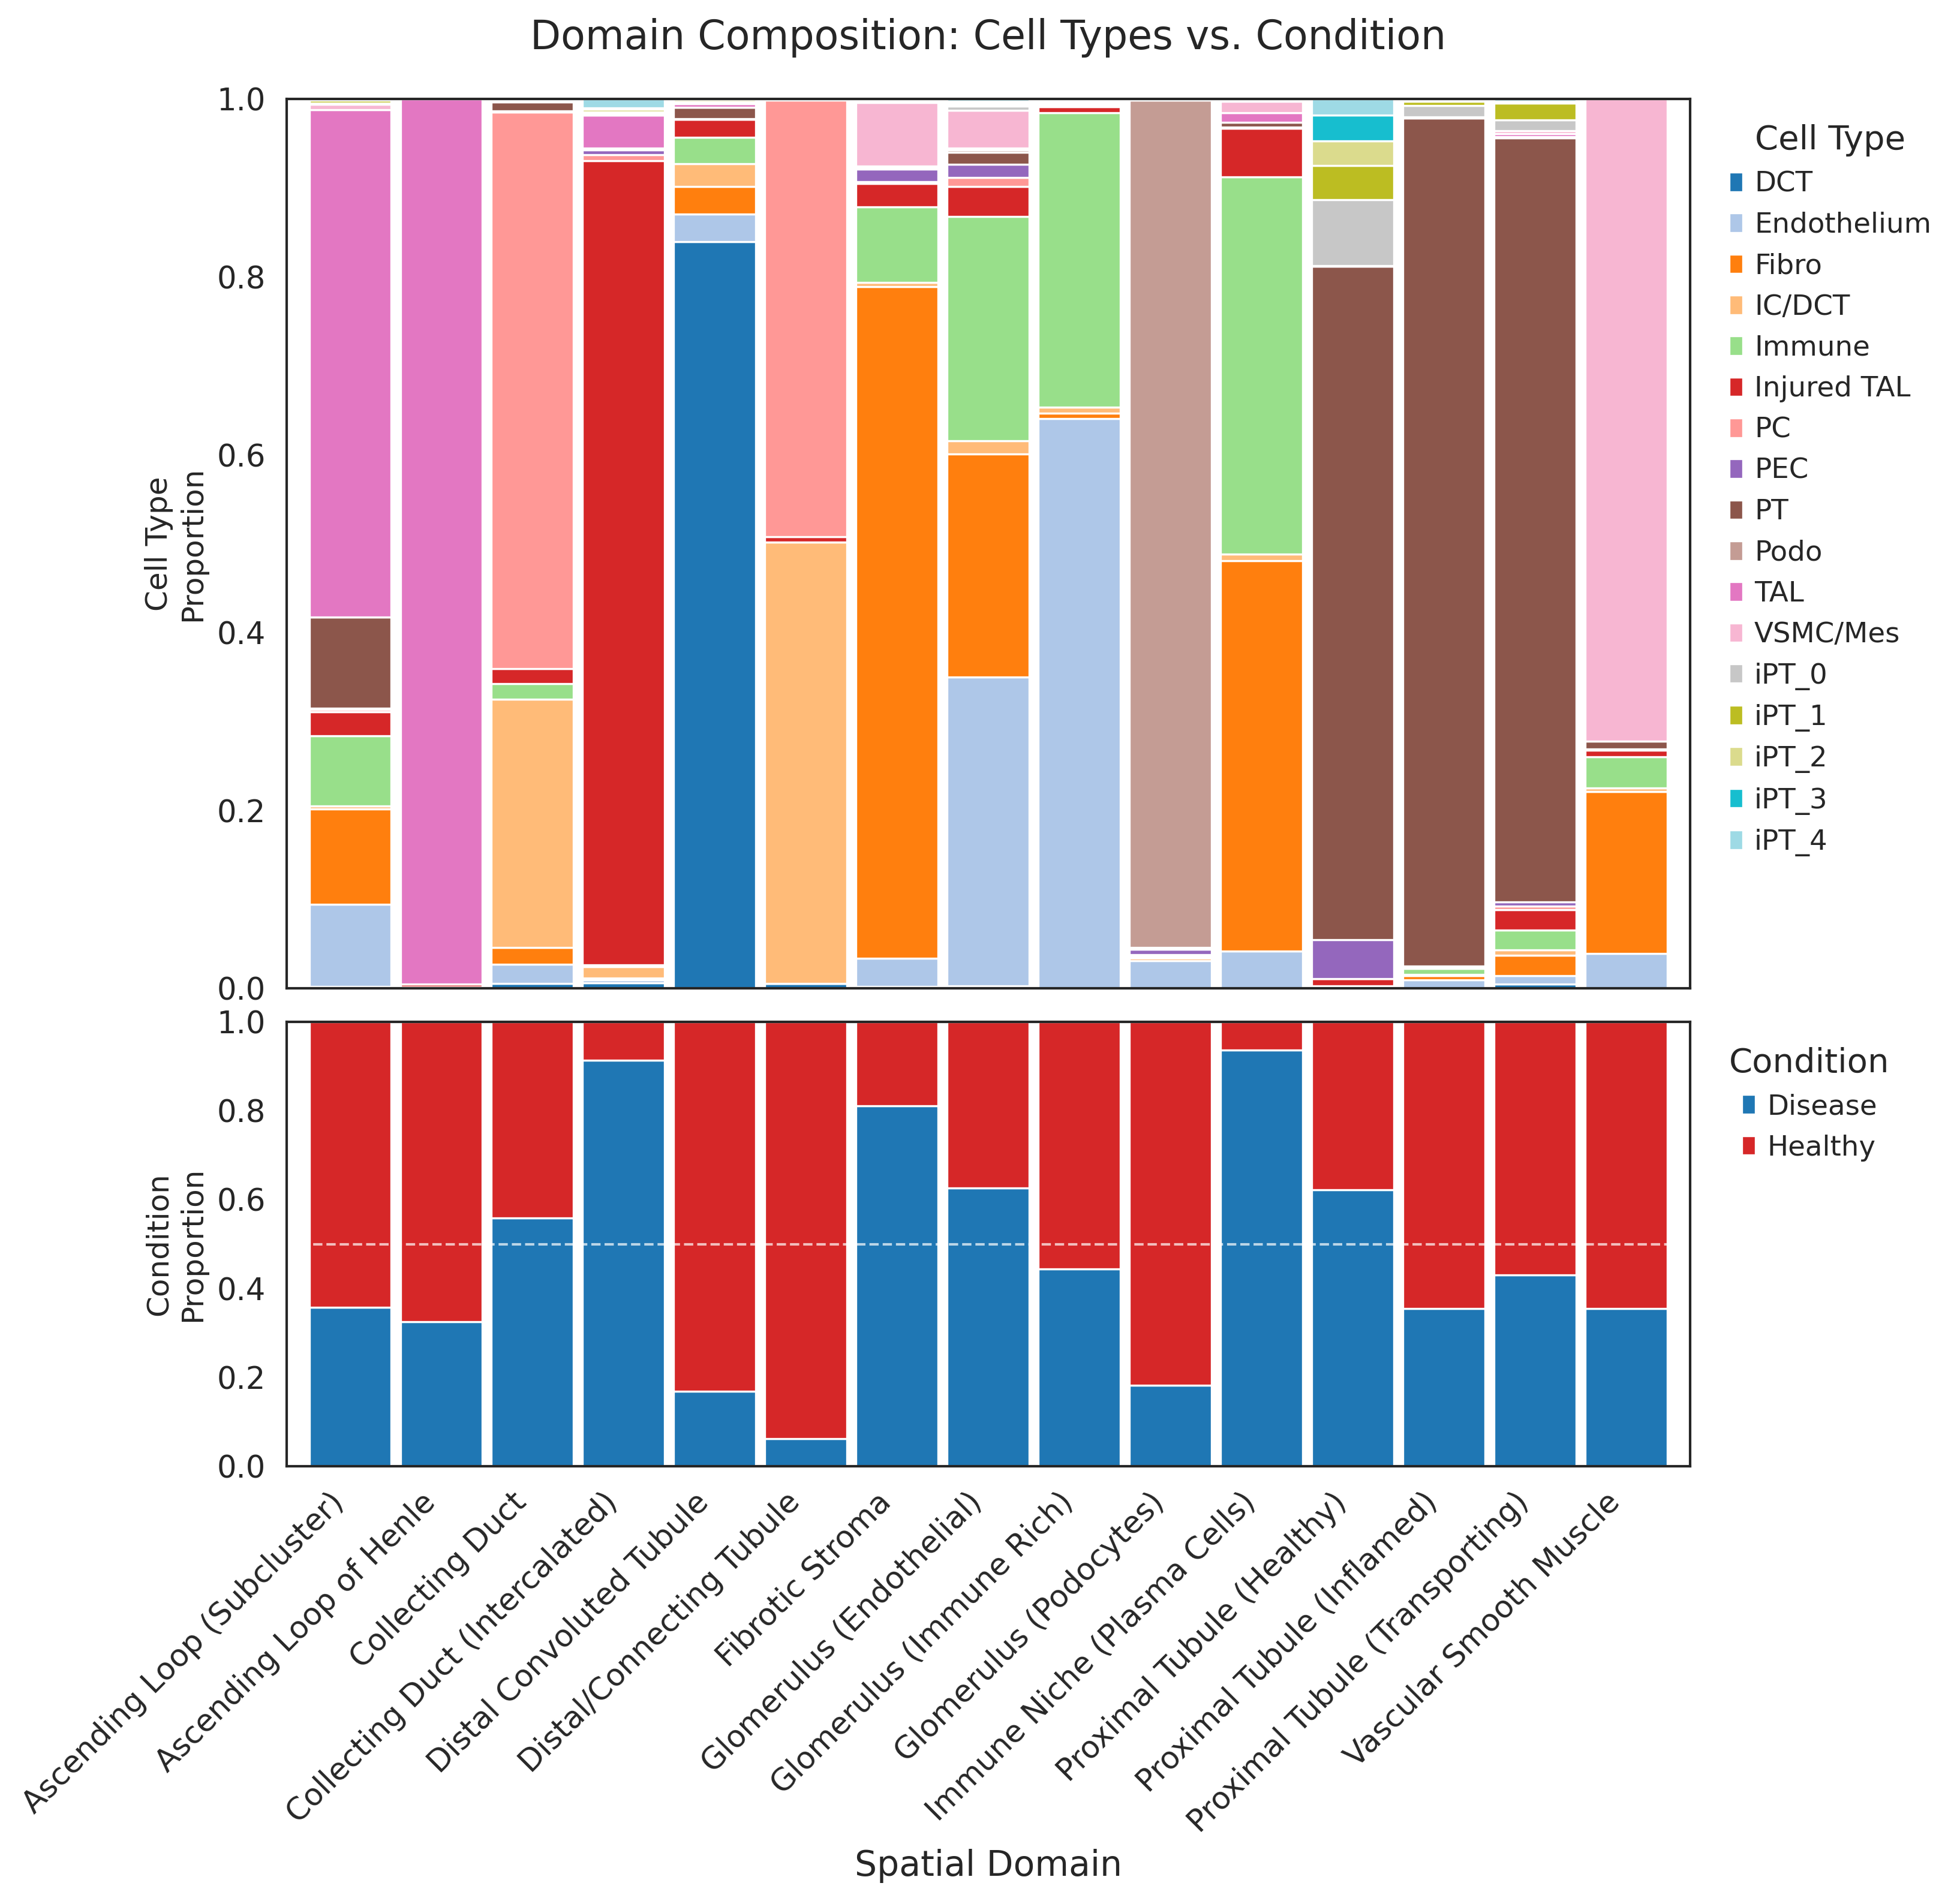

In [6]:
# %%
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings

# --- VISUALIZATION SETTINGS (WHITE THEME) ---
warnings.filterwarnings('ignore')
sns.set_style("white")
sns.set_context("paper", font_scale=1.4)
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['savefig.facecolor'] = 'white'

# --- CONFIGURATION ---
INPUT_FILE = "../../data/Kidney_ST/Kidney_CosMx_BANKSY_Annotated_Final.h5ad"
ANALYSIS_DIR = "../../analysis/banksy_composition_plots"
os.makedirs(ANALYSIS_DIR, exist_ok=True)

# COLUMNS
# Uses annotated column if available
DOMAIN_KEY = 'BANKSY_Domain'
if 'BANKSY_Domain_Annotated' in adata.obs:
    DOMAIN_KEY = 'BANKSY_Domain_Annotated'
elif 'BANKSY_Domain_Summary' in adata.obs:
    DOMAIN_KEY = 'BANKSY_Domain_Summary'

CELL_TYPE_KEY = 'cellType_CosMx_2'
CONDITION_KEY = 'type'

# --- LOAD DATA ---
if 'adata' not in locals():
    print(f"Loading {INPUT_FILE}...")
    adata = sc.read_h5ad(INPUT_FILE)

adata.obs[DOMAIN_KEY] = adata.obs[DOMAIN_KEY].astype('category')

# --- PREPARE DATA ---
print("Calculating proportions...")

# 1. Cell Type Data
df_cell = pd.crosstab(adata.obs[DOMAIN_KEY],
                      adata.obs[CELL_TYPE_KEY], normalize='index')

# 2. Condition Data
if CONDITION_KEY in adata.obs:
    df_cond = pd.crosstab(adata.obs[DOMAIN_KEY],
                          adata.obs[CONDITION_KEY], normalize='index')
else:
    raise ValueError(f"Column '{CONDITION_KEY}' not found!")

# --- SAVE DATA TO CSV ---
df_cell.to_csv(os.path.join(ANALYSIS_DIR, "combined_plot_data_celltype.csv"))
df_cond.to_csv(os.path.join(ANALYSIS_DIR, "combined_plot_data_condition.csv"))

# --- PLOTTING ---
print("Generating Combined Plot...")

# Create 2 subplots sharing the X axis
# hspace=0.1 puts them close together
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(
    10, 10), gridspec_kw={'height_ratios': [2, 1], 'hspace': 0.05})
fig.patch.set_facecolor('white')

# --- TOP PANEL: CELL TYPES ---
df_cell.plot(kind='bar', stacked=True, width=0.9, ax=ax1, colormap='tab20')
ax1.set_ylabel('Cell Type\nProportion', fontsize=12)
ax1.set_title('Domain Composition: Cell Types vs. Condition',
              fontsize=16, pad=20)
# Move legend outside
ax1.legend(bbox_to_anchor=(1.01, 1), loc='upper left',
           frameon=False, title="Cell Type", fontsize='small')
ax1.set_ylim(0, 1)
ax1.grid(False)

# Remove x-labels from top plot to avoid clutter
ax1.tick_params(axis='x', which='both', bottom=False,
                top=False, labelbottom=False)
ax1.set_xlabel('')

# --- BOTTOM PANEL: CONDITIONS ---
# Colors: Blue (Healthy), Red (Disease), Green (Other)
colors = ['#1f77b4', '#d62728', '#2ca02c']
df_cond.plot(kind='bar', stacked=True, width=0.9, ax=ax2, color=colors)

ax2.set_ylabel('Condition\nProportion', fontsize=12)
ax2.set_xlabel('Spatial Domain', fontsize=14)
# Move legend outside
ax2.legend(bbox_to_anchor=(1.01, 1), loc='upper left',
           frameon=False, title="Condition", fontsize='small')
ax2.set_ylim(0, 1)
ax2.grid(False)

# Add reference line at 50%
ax2.axhline(0.5, color='white', linestyle='--', linewidth=1, alpha=0.7)

# Rotate X-axis labels for readability
plt.xticks(rotation=45, ha='right')

# --- SAVE ---
save_name = os.path.join(ANALYSIS_DIR, "7_combined_domain_composition")
plt.savefig(f"{save_name}.png", dpi=300,
            bbox_inches='tight', facecolor='white')
plt.savefig(f"{save_name}.pdf", bbox_inches='tight', facecolor='white')

print(f"Combined plot saved to: {save_name}.png & .pdf")
plt.show()


In [7]:
# %%
import scanpy as sc
import os

# --- CONFIGURATION ---
# We will save it as the "Final" version to distinguish it from the raw calculation
OUTPUT_FILE = "../../data/Kidney_ST/Kidney_CosMx_BANKSY_Annotated_Final.h5ad"
DOMAIN_KEY = 'BANKSY_Domain_Annotated'  # The column with your final names

# --- VERIFICATION ---
print("Checking object before saving...")

# 1. Check if the annotation column exists
if DOMAIN_KEY in adata.obs:
    print(f"✅ Found annotation column: '{DOMAIN_KEY}'")
    print("Preview of domains:")
    print(adata.obs[DOMAIN_KEY].value_counts().head())
else:
    print(f"⚠️ WARNING: Column '{DOMAIN_KEY}' not found.")
    print("Available columns:", adata.obs.columns.tolist())

# 2. Check for the summary column (from auto-enrichment)
if 'BANKSY_Domain_Summary' in adata.obs:
    print(f"✅ Found summary context: 'BANKSY_Domain_Summary'")

# --- SAVE ---
print(f"\nSaving object to: {OUTPUT_FILE} ...")
try:
    adata.write(OUTPUT_FILE)
    print("✅ Success! The AnnData object is saved.")
    print("You can now load this specific file anytime to skip the analysis steps.")
except Exception as e:
    print(f"❌ Error saving file: {e}")


Checking object before saving...
✅ Found annotation column: 'BANKSY_Domain_Annotated'
Preview of domains:
BANKSY_Domain_Annotated
Glomerulus (Endothelial)      94232
Proximal Tubule (Inflamed)    78401
Proximal Tubule (Healthy)     69952
Fibrotic Stroma               50143
Ascending Loop of Henle       49850
Name: count, dtype: int64

Saving object to: ../../data/Kidney_ST/Kidney_CosMx_BANKSY_Annotated_Final.h5ad ...


✅ Success! The AnnData object is saved.
You can now load this specific file anytime to skip the analysis steps.
